In [47]:
from splinter import Browser
from bs4 import BeautifulSoup
from time import sleep
import requests as r
import pandas as pd
from tqdm import tqdm_notebook
import json

import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
browser = Browser('chrome', headless = False)

In [5]:
browser.visit('https://millercenter.org/the-presidency/presidential-speeches')

In [8]:
# Script to load all speeching into the current HTML of the browser
for i in tqdm_notebook(range(100)):
    browser.execute_script("window.scrollTo(0, document.body.scrollHeight);")
    sleep(1)

KeyboardInterrupt: 

In [9]:
html = browser.html

In [10]:
soup = BeautifulSoup(html, 'html.parser')

In [11]:
speeches = soup.find('div', class_ = 'views-infinite-scroll-content-wrapper').find_all('a')

In [12]:
len(speeches)

992

In [13]:
speeches[0]

<a href="/the-presidency/presidential-speeches/september-25-2019-press-conference" hreflang="en">September 25, 2019: Press Conference</a>

In [14]:
speeches[1]['href']

'/the-presidency/presidential-speeches/september-24-2019-remarks-united-nations-general-assembly'

In [15]:
base = 'https://millercenter.org'

In [16]:
response = r.get(base + speeches[0]['href'])

In [17]:
soup = BeautifulSoup(response.text, 'html.parser')

In [18]:
soup.find(class_ = 'transcript-inner').text[:2000]

'\nTranscript\nPRESIDENT TRUMP:\xa0 Thank you very much.\xa0 Thank you.\nWell, thank you all for being here.\xa0 We’ve had a tremendous three days in New York, at the United Nations.\xa0 I want to thank the Secretary-General.\xa0 It’s been really incredible what’s been taking place.\xa0 And he’s been a fantastic host to a lot of countries.\nThe meetings I had on a bilat, or close, were pretty staggering.\xa0 I think we set a new record, but you’ll have to check that out.\xa0 The — we met very, very — for pretty extended periods of time, either two and two, one on one, or just about at that level with Pakistan, Poland, New Zealand, Singapore, Egypt, South Korea, United Kingdom, India, Iraq, Argentina, Germany, Brazil, France, Japan, Ukraine, Honduras, El Salvador, Saudi Arabia, Jordan, Bahrain, Kuwait, Qatar, Oman, UAE, Chile, Colombia, Ecuador, and Peru.\xa0 Other than that, we weren’t too busy over the last three days.\nAnd, unfortunately, the press doesn’t even cover it.\xa0 You know

In [19]:
soup.find(class_ = 'president-name').text

'Donald Trump'

In [23]:
links = (base + speech['href'] for speech in speeches)

In [24]:
transcripts = []
ungotten_links = []
for link in tqdm_notebook(links, total = len(speeches)):
    response = r.get(link)
    
    if response.status_code == 200:
        soup = BeautifulSoup(response.text, 'html.parser')
        try:
            transcripts.append({
                'president': soup.find('p', class_ = 'president-name').text,
                'date': soup.find('p', class_ = 'episode-date').text,
                'transcript': soup.find(class_ = 'transcript-inner').text
            })
        except:
            ungotten_links.append(link)

In [25]:
print('num Transcripts retrieved:', len(transcripts))
print('num Transcripts in diff format:', len(ungotten_links))

num Transcripts retrieved: 476
num Transcripts in diff format: 515


In [28]:
with open('transcripts.json', 'w') as f:
    json.dump(transcripts, f)
    print('Dumped')

Dumped


In [29]:
with open('ungotten_links.json', 'w') as f:
    json.dump(ungotten_links, f)

In [4]:
with open('transcripts.json', 'r') as f:
    transcripts = json.load(f)

In [5]:
with open('ungotten_links.json', 'r') as f:
    ungotten_links = json.load(f)

In [7]:
links = (i for i in ungotten_links)
ungotten_links2 = []
for link in tqdm_notebook(links, total = len(ungotten_links)):
    response = r.get(link)
    
    if response.status_code == 200:
        soup = BeautifulSoup(response.text, 'html.parser')
        try:
            transcripts.append({
                'president': soup.find('p', class_ = 'president-name').text,
                'date': soup.find('p', class_ = 'episode-date').text,
                'transcript': soup.find(class_ = 'view-transcript').text
            })
        except:
            ungotten_links2.append(link)

In [8]:
print('num Transcripts retrieved:', len(transcripts))
print('num Transcripts in diff format:', len(ungotten_links2))

num Transcripts retrieved: 991
num Transcripts in diff format: 0


In [9]:
with open('transcripts.json', 'w') as f:
    json.dump(transcripts, f)
    print('Dumped')

Dumped


In [16]:
df = pd.DataFrame(transcripts)
df.tail()

,date,president,transcript
986,"December 29, 1790",George Washington,Transcript I the President of the United State...
987,"December 08, 1790",George Washington,Transcript Fellow citizens of the Senate and H...
988,"January 08, 1790",George Washington,TranscriptFellow Citizens of the Senate and Ho...
989,"October 03, 1789",George Washington,TranscriptWhereas it is the duty of all Nation...
990,"April 30, 1789",George Washington,TranscriptFellow Citizens of the Senate and th...


In [38]:
def remove_transcript(string):
    first_chars = string[0:50]
    rest_chars = string[50::]
    
    first_chars = first_chars.replace('Transcript', '')
    first_chars = first_chars.replace('\nTranscript\n', '')
    return (first_chars + rest_chars).strip()

In [39]:
df['transcript'] = df['transcript'].apply(lambda x: remove_transcript(x))

In [40]:
df.head()

,date,president,transcript
0,"September 25, 2019",Donald Trump,PRESIDENT TRUMP: Thank you very much. Thank ...
1,"September 24, 2019",Donald Trump,PRESIDENT TRUMP: Thank you very much. Mr. Pr...
2,"February 15, 2019",Donald Trump,"THE PRESIDENT: Thank you very much, everybody..."
3,"February 05, 2019",Donald Trump,"Madam Speaker, Mr. Vice President, Members of ..."
4,"January 19, 2019",Donald Trump,"THE PRESIDENT: Just a short time ago, I had th..."


In [45]:
df['president'].nunique()

44

In [46]:
lengths = [len(i) for i in df['transcript']]

Text(0.5, 1.0, 'Character count distribution for all speeches')

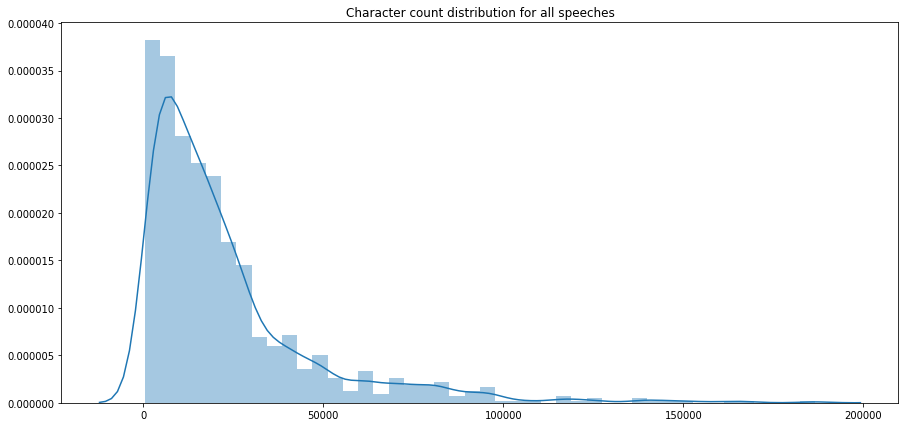

In [52]:
ax = plt.figure(figsize=(15, 7))
sns.distplot(lengths)
plt.title('Character count distribution for all speeches')

Text(0.5, 1.0, 'Character count distribution for all speeches')

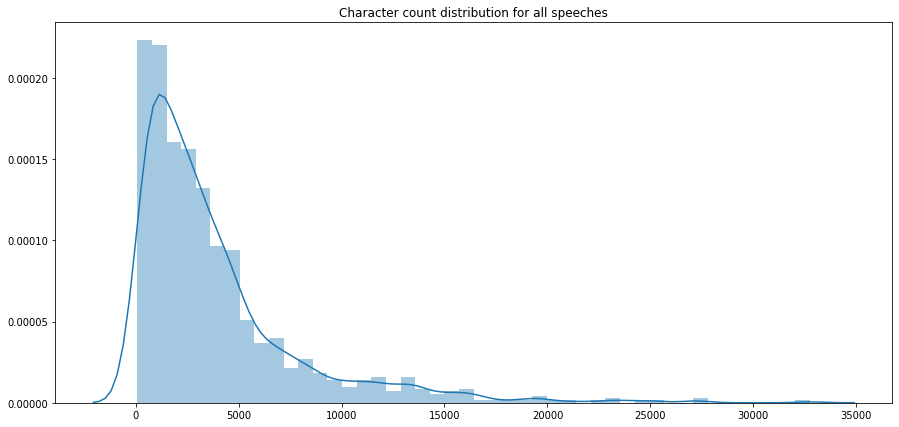

In [54]:
token_count = [len(i.split()) for i in df['transcript']]

ax = plt.figure(figsize=(15, 7))
sns.distplot(token_count)
plt.title('Character count distribution for all speeches')

In [55]:
df['num_tokens'] = [len(i.split()) for i in df['transcript']]

In [56]:
df.describe()

,num_tokens
count,991.000000
mean,3901.732593
std,4141.365120
min,83.000000
25%,1156.500000
50%,2577.000000
75%,4766.000000
max,32755.000000


In [ ]:
df.to_json('transcripts.json')